#  Data Preprocessing & Feature Engineering

##  Notebook Overview
This notebook implements the complete preprocessing pipeline required for building a multimodal property price prediction system. It prepares both tabular housing data and satellite imagery so they can be jointly used in a multimodal regression framework.

##  What This Notebook Covers
- Exploratory Data Analysis (EDA) of tabular housing features to understand price behavior, feature distributions, and spatial patterns  
- Feature engineering on numerical data, including log transformations, ratio-based features, interaction terms, temporal attributes, and location-based features  
- Programmatic acquisition of satellite images for the training dataset using latitude and longitude coordinates  
- Extraction of visual feature embeddings from satellite images using a Convolutional Neural Network (CNN) for both training and validation splits  

##  Outcome
The final output of this notebook is a clean, feature-rich multimodal dataset where engineered tabular features are aligned with CNN-extracted image embeddings. This processed data is used directly in the multimodal model training and evaluation stage.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/multimodal-real-estate/data/raw/train(1).xlsx"

df = pd.read_excel(TRAIN_PATH)

print("Shape:", df.shape)
df.head()


Shape: (16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


#EXPLORATORY DATA ANALYSIS
> In this section, comprehensive exploratory data analysis was performed to understand price behavior, feature distributions, and spatial patterns within the housing dataset. Price distributions were examined using raw, log-transformed, and boxplot visualizations to identify skewness and outliers. Size-related attributes and temporal features were analyzed to assess their spread and relevance, while correlation analysis and feature–price relationships helped highlight the most influential numerical variables. Categorical and location-driven factors such as grade, condition, view, and waterfront presence were explored to capture qualitative value drivers. Finally, geographic and spatial visualizations using latitude and longitude revealed clear location-based price clustering, reinforcing the importance of environmental and neighborhood context for multimodal modeling.

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [ ]:
# Missing values
df.isna().sum().sort_values(ascending=False)


,0
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [ ]:
# Duplicate rows
df.duplicated().sum()


np.int64(0)

In [ ]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,16209.0,4.575771e+09,2.874661e+09,1.000102e+06,2.123049e+09,3.904950e+09,7.304301e+09,9.900000e+09
price,16209.0,5.374703e+05,3.603036e+05,7.500000e+04,3.200000e+05,4.500000e+05,6.400000e+05,7.700000e+06
bedrooms,16209.0,3.367820e+00,9.332701e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,16209.0,2.113054e+00,7.652419e-01,0.000000e+00,1.500000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,16209.0,2.073275e+03,9.070095e+02,2.900000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.205000e+04
sqft_lot,16209.0,1.486767e+04,3.882570e+04,5.200000e+02,5.004000e+03,7.599000e+03,1.063100e+04,1.164794e+06
floors,16209.0,1.498828e+00,5.430321e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,16209.0,6.971436e-03,8.320614e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,16209.0,2.342526e-01,7.631515e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,16209.0,3.407860e+00,6.515529e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [ ]:
df["price"].describe()


,price
count,1.620900e+04
mean,5.374703e+05
std,3.603036e+05
min,7.500000e+04
25%,3.200000e+05
50%,4.500000e+05
75%,6.400000e+05
max,7.700000e+06


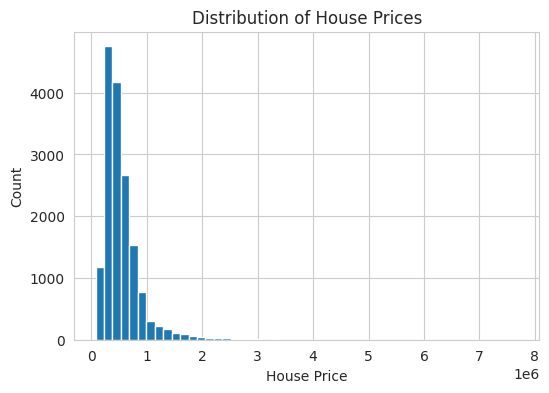

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["price"], bins=50)
plt.xlabel("House Price")
plt.ylabel("Count")
plt.title("Distribution of House Prices")
plt.show()


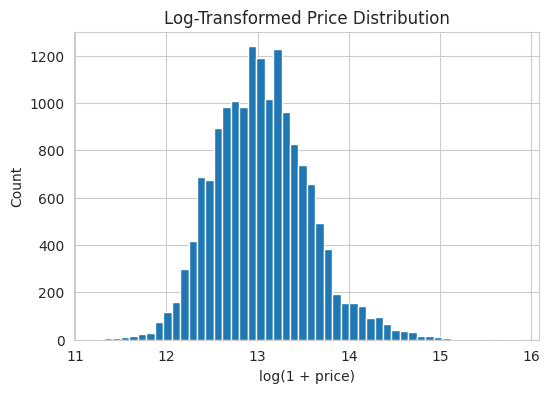

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(df["price"]), bins=50)
plt.xlabel("log(1 + price)")
plt.ylabel("Count")
plt.title("Log-Transformed Price Distribution")
plt.show()


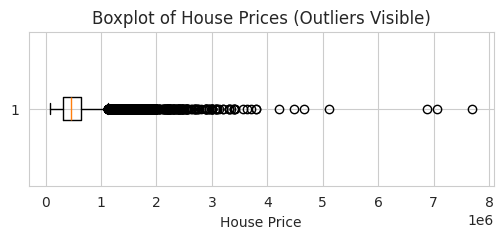

In [ ]:
plt.figure(figsize=(6,2))
plt.boxplot(df["price"], vert=False)
plt.xlabel("House Price")
plt.title("Boxplot of House Prices (Outliers Visible)")
plt.show()


In [ ]:
percentiles = df["price"].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
percentiles


,price
0.01,154536.0
0.05,210000.0
0.25,320000.0
0.50,450000.0
0.75,640000.0
0.95,1150000.0
0.99,1944600.0


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols


['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

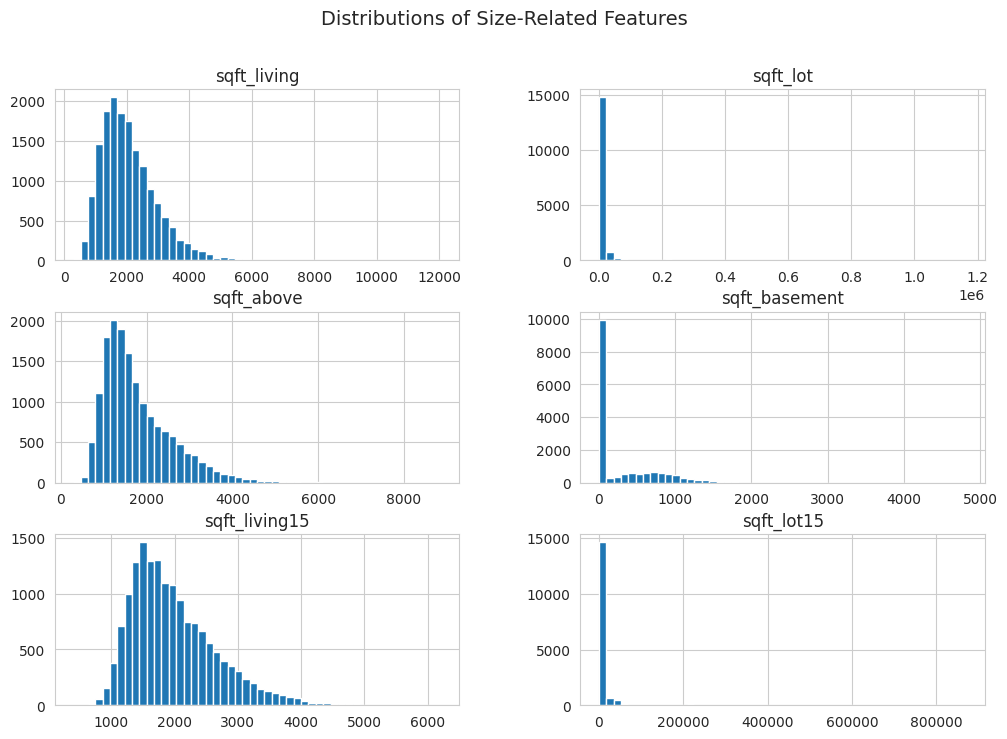

In [ ]:
size_features = [
    "sqft_living",
    "sqft_lot",
    "sqft_above",
    "sqft_basement",
    "sqft_living15",
    "sqft_lot15"
]

df[size_features].hist(
    bins=50,
    figsize=(12,8),
    layout=(3,2)
)
plt.suptitle("Distributions of Size-Related Features", fontsize=14)
plt.show()


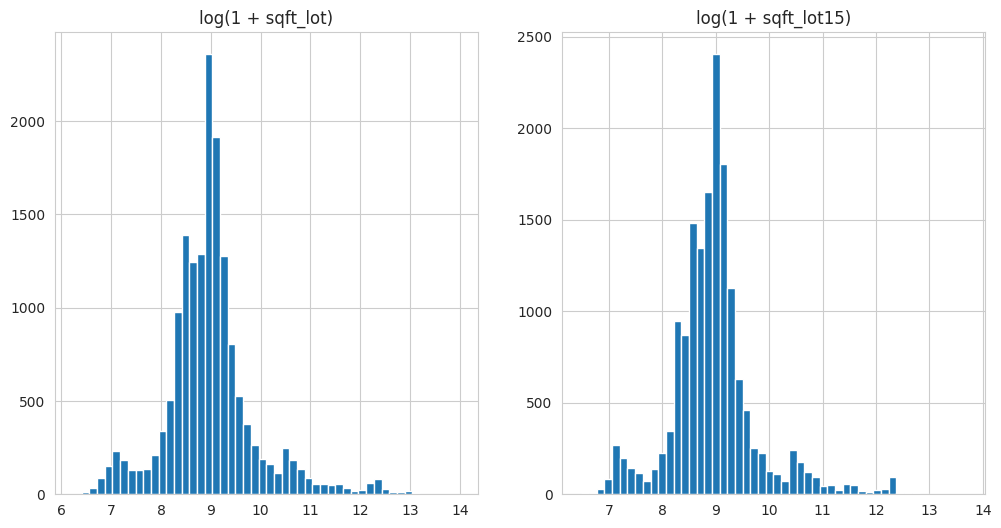

In [ ]:
plt.figure(figsize=(12,6))

for i, col in enumerate(["sqft_lot", "sqft_lot15"]):
    plt.subplot(1, 2, i+1)
    plt.hist(np.log1p(df[col]), bins=50)
    plt.title(f"log(1 + {col})")

plt.show()


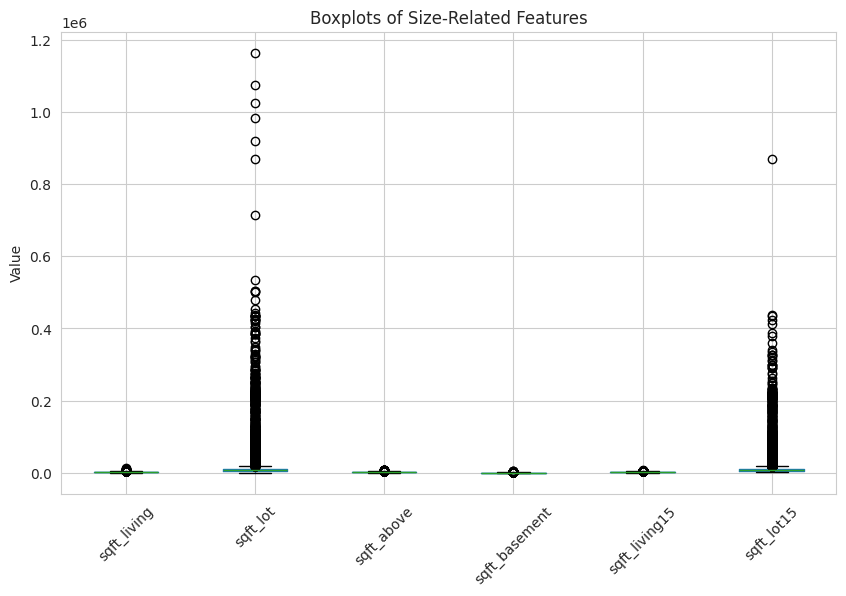

In [ ]:
plt.figure(figsize=(10,6))
df[size_features].boxplot(rot=45)
plt.title("Boxplots of Size-Related Features")
plt.ylabel("Value")
plt.show()


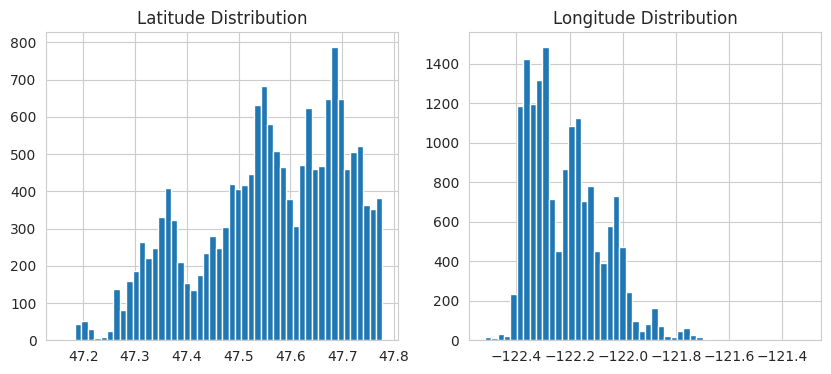

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df["lat"], bins=50)
plt.title("Latitude Distribution")

plt.subplot(1,2,2)
plt.hist(df["long"], bins=50)
plt.title("Longitude Distribution")

plt.show()


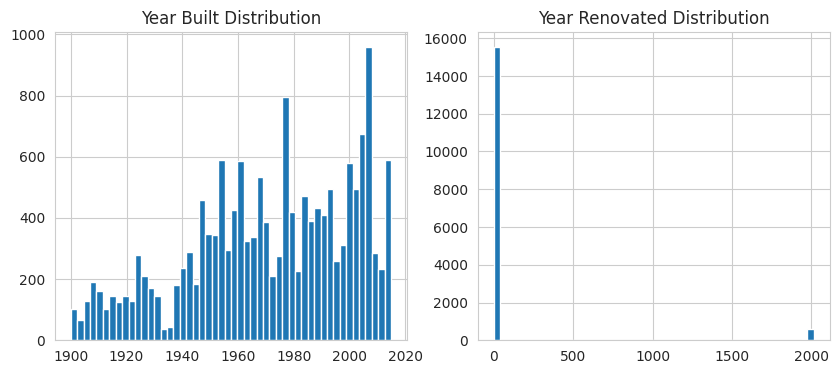

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df["yr_built"], bins=50)
plt.title("Year Built Distribution")

plt.subplot(1,2,2)
plt.hist(df["yr_renovated"], bins=50)
plt.title("Year Renovated Distribution")

plt.show()


ff

In [ ]:
corr_with_price = (
    df.select_dtypes(include=[np.number])
      .corr()["price"]
      .sort_values(ascending=False)
)

corr_with_price


,price
price,1.000000
sqft_living,0.700933
grade,0.664266
sqft_above,0.602648
sqft_living15,0.581781
bathrooms,0.525487
view,0.390534
sqft_basement,0.320301
lat,0.310008
bedrooms,0.304454


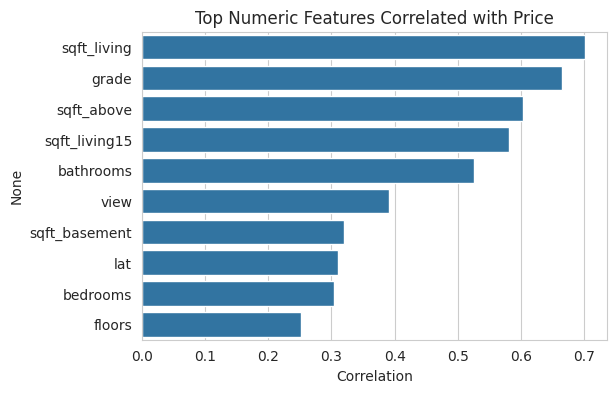

In [ ]:
top_corr = corr_with_price.drop("price").head(10)

plt.figure(figsize=(6,4))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top Numeric Features Correlated with Price")
plt.xlabel("Correlation")
plt.show()


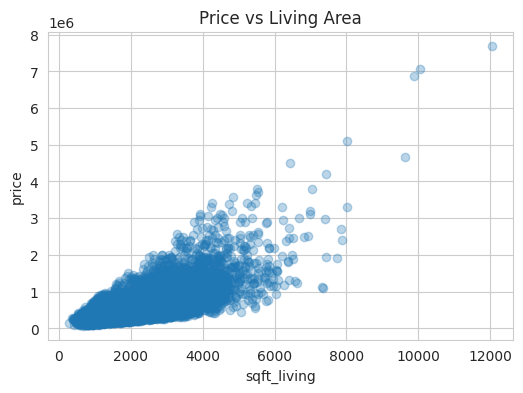

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df["sqft_living"], df["price"], alpha=0.3)
plt.xlabel("sqft_living")
plt.ylabel("price")
plt.title("Price vs Living Area")
plt.show()


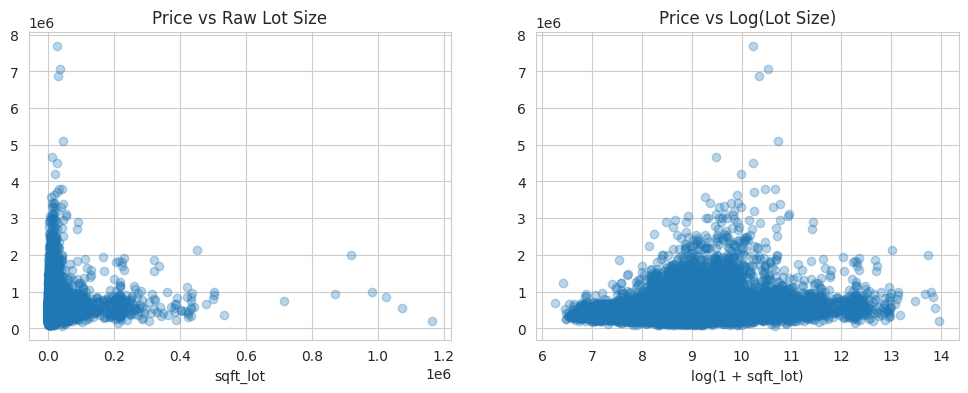

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(df["sqft_lot"], df["price"], alpha=0.3)
plt.title("Price vs Raw Lot Size")
plt.xlabel("sqft_lot")

plt.subplot(1,2,2)
plt.scatter(np.log1p(df["sqft_lot"]), df["price"], alpha=0.3)
plt.title("Price vs Log(Lot Size)")
plt.xlabel("log(1 + sqft_lot)")

plt.show()


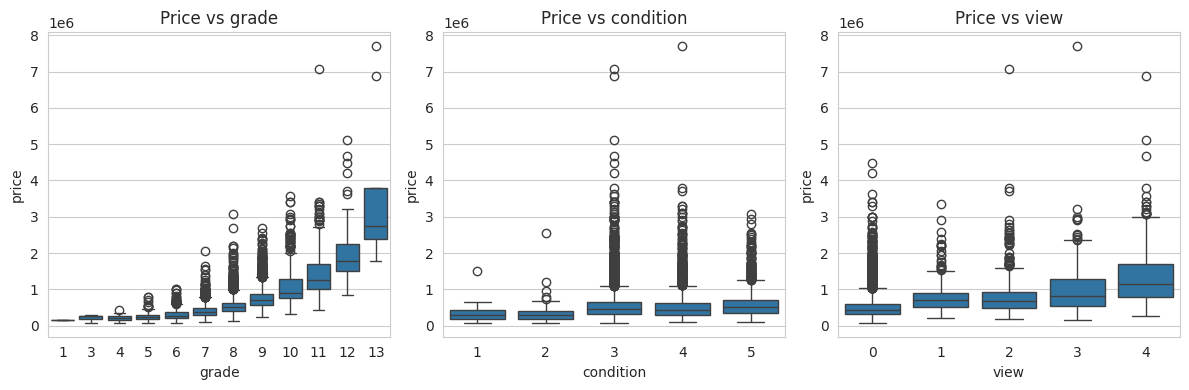

In [ ]:
ordinal_features = ["grade", "condition", "view"]

plt.figure(figsize=(12,4))
for i, col in enumerate(ordinal_features):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=df[col], y=df["price"])
    plt.title(f"Price vs {col}")

plt.tight_layout()
plt.show()


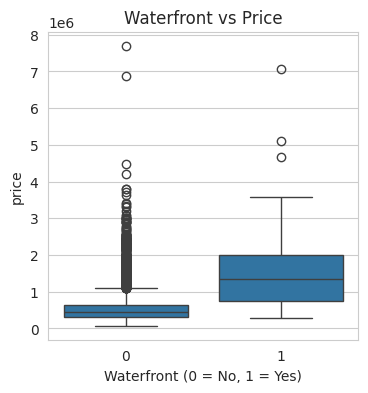

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(x=df["waterfront"], y=df["price"])
plt.title("Waterfront vs Price")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.show()


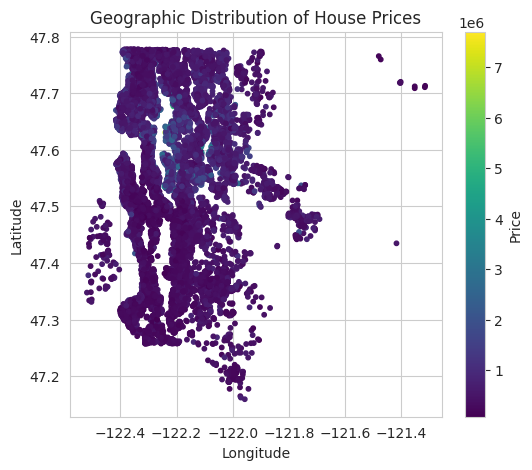

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df["long"], df["lat"], c=df["price"], cmap="viridis", s=10)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of House Prices")
plt.show()


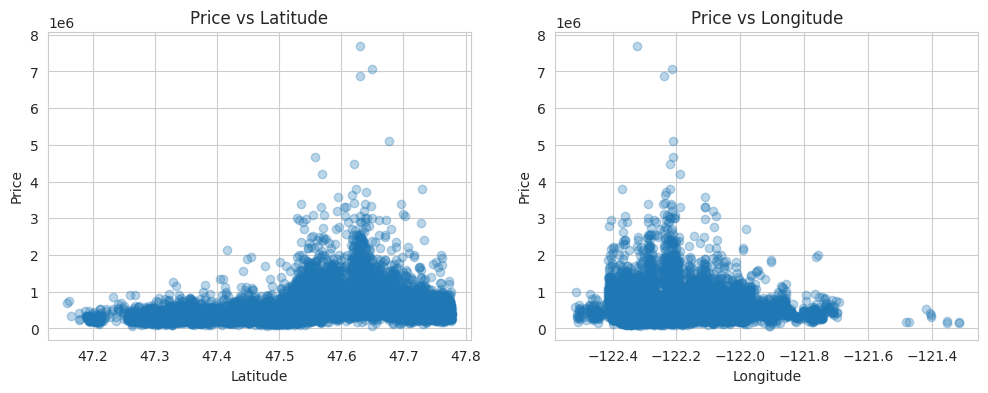

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(df["lat"], df["price"], alpha=0.3)
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.title("Price vs Latitude")

plt.subplot(1,2,2)
plt.scatter(df["long"], df["price"], alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.title("Price vs Longitude")

plt.show()


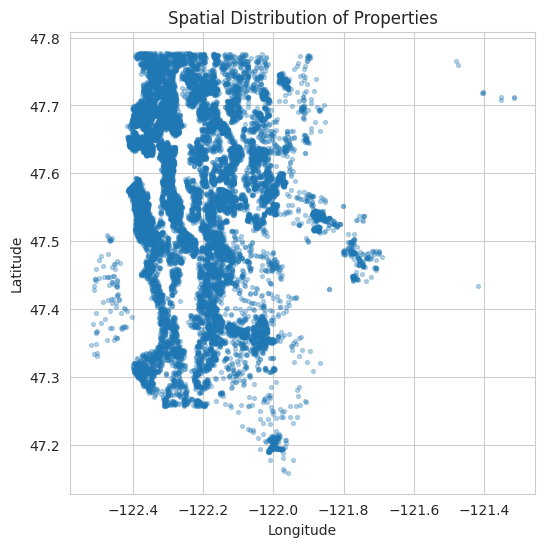

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df["long"], df["lat"], s=8, alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Properties")
plt.show()


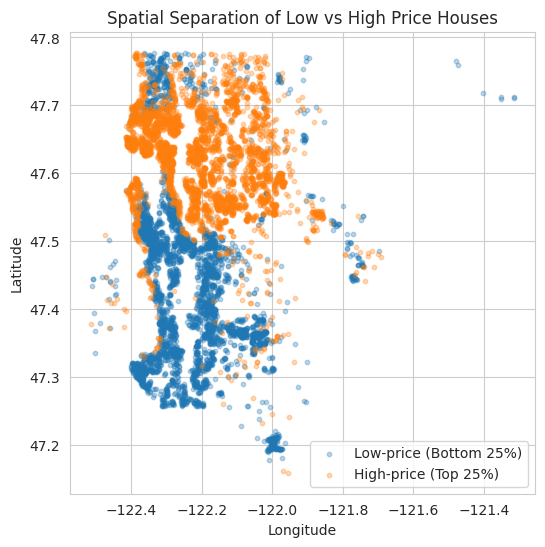

In [ ]:
low_thresh = df["price"].quantile(0.25)
high_thresh = df["price"].quantile(0.75)

plt.figure(figsize=(6,6))

plt.scatter(
    df[df["price"] <= low_thresh]["long"],
    df[df["price"] <= low_thresh]["lat"],
    s=10, alpha=0.3, label="Low-price (Bottom 25%)"
)

plt.scatter(
    df[df["price"] >= high_thresh]["long"],
    df[df["price"] >= high_thresh]["lat"],
    s=10, alpha=0.3, label="High-price (Top 25%)"
)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Separation of Low vs High Price Houses")
plt.show()


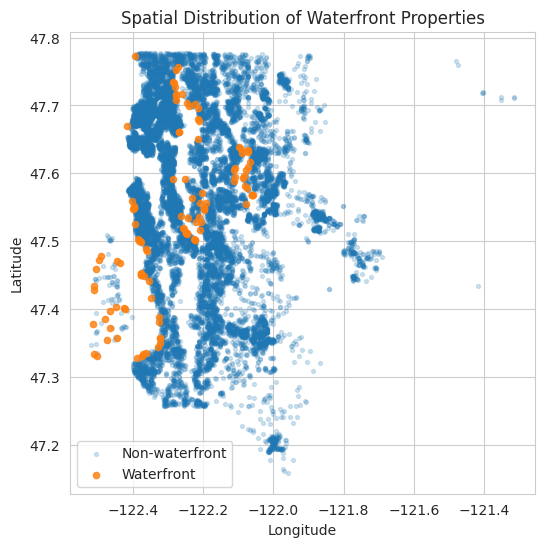

In [ ]:
plt.figure(figsize=(6,6))

plt.scatter(
    df[df["waterfront"] == 0]["long"],
    df[df["waterfront"] == 0]["lat"],
    s=8, alpha=0.2, label="Non-waterfront"
)

plt.scatter(
    df[df["waterfront"] == 1]["long"],
    df[df["waterfront"] == 1]["lat"],
    s=20, alpha=0.8, label="Waterfront"
)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Waterfront Properties")
plt.show()


#TABULAR FEATURE ENGINEERING

>  To enhance the predictive power of the tabular dataset, several domain-informed features were engineered to capture structural, temporal, and spatial characteristics of properties more effectively.

>  Price and size-related variables were log-transformed to reduce skewness and stabilize variance. Ratio-based features were introduced to represent relative space utilization, such as the proportion of basement and above-ground area, lot utilization efficiency, and comparisons with neighboring properties. These features help normalize raw sizes and capture contextual differences between homes.

>  Temporal features were created to model property age and renovation effects, including house age, renovation indicators, and years since last renovation. Additional interaction features combining grade, view, and living area were added to capture qualitative construction attributes in a quantitative form.

>  Finally, geographic features such as distance from the city center and latitude–longitude interactions were engineered to better represent location-based value patterns. Together, these engineered features provide a richer numerical representation of each property, forming a strong foundation for both tabular-only and multimodal regression models.

In [ ]:
import pandas as pd
import numpy as np

DATA_DIR = "/content/drive/MyDrive/multimodal-real-estate/data"

# Load base cleaned data
train_df = pd.read_excel(f"{DATA_DIR}/raw/train(1).xlsx")



In [ ]:
train_df['price_log'] = np.log1p(train_df['price'])


In [ ]:
train_df['basement_ratio'] = train_df['sqft_basement'] / (train_df['sqft_living'] + 1)
train_df['above_ratio'] = train_df['sqft_above'] / (train_df['sqft_living'] + 1)
train_df['lot_utilization'] = train_df['sqft_living'] / (train_df['sqft_lot'] + 1)


In [ ]:
train_df['living_vs_neighbors'] = train_df['sqft_living'] / (train_df['sqft_living15'] + 1)
train_df['lot_vs_neighbors'] = train_df['sqft_lot'] / (train_df['sqft_lot15'] + 1)


In [ ]:
CURRENT_YEAR = 2015

train_df['house_age'] = CURRENT_YEAR - train_df['yr_built']
train_df['is_renovated'] = (train_df['yr_renovated'] > 0).astype(int)

train_df['years_since_renovation'] = np.where(
    train_df['yr_renovated'] > 0,
    CURRENT_YEAR - train_df['yr_renovated'],
    train_df['house_age']
)


In [ ]:
train_df['bath_per_bed'] = train_df['bathrooms'] / (train_df['bedrooms'] + 1)
train_df['rooms_total'] = train_df['bedrooms'] + train_df['bathrooms']


In [ ]:
train_df['grade_sqft_interaction'] = train_df['grade'] * train_df['sqft_living']
train_df['view_grade_interaction'] = train_df['view'] * train_df['grade']


In [ ]:
LAT_C, LON_C = 47.6062, -122.3321  # Seattle center

train_df['dist_to_city_center'] = np.sqrt(
    (train_df['lat'] - LAT_C)**2 + (train_df['long'] - LON_C)**2
)

train_df['lat_long_interaction'] = train_df['lat'] * train_df['long']


In [ ]:
train_df['log_sqft_living'] = np.log1p(train_df['sqft_living'])
train_df['log_sqft_lot'] = np.log1p(train_df['sqft_lot'])
train_df['log_sqft_lot15'] = np.log1p(train_df['sqft_lot15'])


In [ ]:
TARGET = "price_log"

DROP_COLS = [
    "id",
    "zipcode",
    "price",
    "price_log",
    "date",
    "yr_built",
    "yr_renovated"
]

FEATURE_COLS = [c for c in train_df.columns if c not in DROP_COLS]

X = train_df[FEATURE_COLS]
y = train_df[TARGET]

print("Number of features:", X.shape[1])


Number of features: 32


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [ ]:
PROCESSED_DIR = f"{DATA_DIR}/processed"

X_train.to_csv(f"{PROCESSED_DIR}/X_train.csv", index=False)
X_val.to_csv(f"{PROCESSED_DIR}/X_val.csv", index=False)
y_train.to_csv(f"{PROCESSED_DIR}/y_train.csv", index=False)
y_val.to_csv(f"{PROCESSED_DIR}/y_val.csv", index=False)

print("✅ Processed data overwritten successfully")


✅ Processed data overwritten successfully


#Satellite Image Download (Training Data)
> ### Satellite images for the training dataset were programmatically downloaded using latitude and longitude coordinates via a custom data-fetching script. These images capture neighborhood-level visual context and are aligned with tabular records to enable multimodal model training.

In [ ]:
import pandas as pd

# Load your original training Excel file
df = pd.read_excel("train(1).xlsx")

# Select ONLY required columns for image fetching
image_df = df[["id", "lat", "long"]]

# Save new CSV for Mapbox image fetching
image_df.to_csv("train_image_coords.csv", index=False)

print("train_image_coords.csv created successfully!")
image_df.head()


train_image_coords.csv created successfully!


,id,lat,long
0,9117000170,47.4362,-122.187
1,6700390210,47.4034,-122.187
2,7212660540,47.2704,-122.313
3,8562780200,47.5321,-122.073
4,7760400350,47.3715,-122.074


In [ ]:
!cp /content/train_image_coords.csv \
   /content/drive/MyDrive/multimodal-real-estate/data/processed/


In [ ]:
!cp /content/data_fetcher.py \
   /content/drive/MyDrive/multimodal-real-estate/


In [ ]:
!python data_fetcher.py

Loading coordinate CSV...
Total rows in CSV: 16209
Saving images to: /content/drive/MyDrive/multimodal-real-estate/data/raw/images/train
--------------------------------------------------
[100/16209] Downloaded: 100 | Skipped: 0 | Failed: 0
[200/16209] Downloaded: 200 | Skipped: 0 | Failed: 0
[300/16209] Downloaded: 300 | Skipped: 0 | Failed: 0
[400/16209] Downloaded: 400 | Skipped: 0 | Failed: 0
[500/16209] Downloaded: 500 | Skipped: 0 | Failed: 0
[600/16209] Downloaded: 600 | Skipped: 0 | Failed: 0
[700/16209] Downloaded: 700 | Skipped: 0 | Failed: 0
[800/16209] Downloaded: 800 | Skipped: 0 | Failed: 0
[900/16209] Downloaded: 900 | Skipped: 0 | Failed: 0
[1000/16209] Downloaded: 1000 | Skipped: 0 | Failed: 0
[1100/16209] Downloaded: 1100 | Skipped: 0 | Failed: 0
[1200/16209] Downloaded: 1200 | Skipped: 0 | Failed: 0
[1300/16209] Downloaded: 1300 | Skipped: 0 | Failed: 0
[1400/16209] Downloaded: 1400 | Skipped: 0 | Failed: 0
[1500/16209] Downloaded: 1500 | Skipped: 0 | Failed: 0
[1600

#Multimodal Data Preparation
> ### To enable multimodal learning, visual features were extracted from satellite images using a Convolutional Neural Network (CNN). The image dataset was processed in two stages corresponding to the training and validation splits.

> ### In each stage, images were passed through the CNN to generate high-dimensional feature embeddings, which were then aligned with the corresponding tabular records. This ensures that both numerical and visual representations are consistently prepared for multimodal regression.

##1) TRAIN DATASET IMAGE EMBEDDINGS

In [ ]:
import torch
from torchvision import transforms

# Image preprocessing pipeline
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # Required for ResNet
    transforms.ToTensor(),           # Converts image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

print("Image transforms defined successfully")


Image transforms defined successfully


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class MultimodalHouseDataset(Dataset):
    def __init__(self, X, y, image_dir, transform=None):
        """
        X : DataFrame containing tabular features + 'id'
        y : Series or array of prices
        image_dir : directory where images are stored
        transform : torchvision transforms
        """
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Tabular features
        row = self.X.iloc[idx]
        house_id = int(row["id"])

        tabular_features = torch.tensor(
            row.drop("id").values,
            dtype=torch.float32
        )

        # Image loading (handle .jpg and .0.jpg)
        img_path_1 = os.path.join(self.image_dir, f"id_{house_id}.jpg")
        img_path_2 = os.path.join(self.image_dir, f"id_{float(house_id)}.jpg")

        img_path = img_path_1 if os.path.exists(img_path_1) else img_path_2

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Target
        price = torch.tensor(self.y.iloc[idx], dtype=torch.float32)

        return image, tabular_features, price


In [ ]:
import pandas as pd

DATA_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/processed"
IMAGE_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/raw/images/train"

# Load cleaned tabular data
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv").squeeze()

# Load IDs for alignment
ids_df = pd.read_csv(f"{DATA_DIR}/train_image_coords.csv")

# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
ids_df = ids_df.reset_index(drop=True)

# Attach id ONLY for dataset usage
X_train_mm = X_train.copy()
X_train_mm["id"] = ids_df["id"]

print(X_train_mm.shape, y_train.shape)
X_train_mm.head()


(12967, 33) (12967,)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,bath_per_bed,rooms_total,grade_sqft_interaction,view_grade_interaction,dist_to_city_center,lat_long_interaction,log_sqft_living,log_sqft_lot,log_sqft_lot15,id
0,3,1.00,1220,6600,1.0,0,0,3,6,1220,...,0.250000,4.00,7320,0,0.510860,-5790.400762,7.107425,8.794976,8.794976,9117000170
1,2,2.00,2010,3797,1.5,0,0,3,7,1450,...,0.666667,4.00,14070,0,0.049638,-5817.252474,7.606387,8.242230,8.444838,6700390210
2,4,2.50,2570,7980,2.0,0,0,3,9,2570,...,0.500000,6.50,23130,0,0.268963,-5814.908057,7.852050,8.984819,8.834483,7212660540
3,4,2.25,2740,11343,1.0,0,2,5,10,1980,...,0.450000,6.25,27400,20,0.118562,-5834.091253,7.916078,9.336444,9.213136,8562780200
4,4,5.25,5240,320917,2.0,0,2,3,10,5240,...,1.050000,9.25,52400,20,0.429538,-5797.862753,8.564268,12.678941,11.139322,7760400350


In [ ]:
train_dataset = MultimodalHouseDataset(
    X=X_train_mm,
    y=y_train,
    image_dir=IMAGE_DIR,
    transform=image_transforms
)

print("Dataset length:", len(train_dataset))


Dataset length: 12967


In [ ]:
image, tabular, price = train_dataset[0]

print("Image shape:", image.shape)
print("Tabular shape:", tabular.shape)
print("Price:", price)


Image shape: torch.Size([3, 224, 224])
Tabular shape: torch.Size([32])
Price: tensor(12.5662)


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Train DataLoader created")


Train DataLoader created


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet-18
resnet = models.resnet18(pretrained=True)

# Remove final classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Freeze CNN weights
for param in resnet.parameters():
    param.requires_grad = False

# Move model to device
resnet = resnet.to(device)
resnet.eval()

print("ResNet-18 loaded and frozen")


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


ResNet-18 loaded and frozen


In [ ]:
import torch
import numpy as np

def extract_image_embeddings(model, dataloader, device):
    model.eval()

    all_img_features = []
    all_tabular = []
    all_targets = []

    with torch.no_grad():
        for images, tabular, targets in dataloader:
            images = images.to(device)

            # Forward pass through ResNet
            features = model(images)
            features = features.view(features.size(0), -1)  # Flatten to [B, 512]

            all_img_features.append(features.cpu().numpy())
            all_tabular.append(tabular.numpy())
            all_targets.append(targets.numpy())

    # Concatenate batches
    X_img = np.vstack(all_img_features)
    X_tab = np.vstack(all_tabular)
    y = np.concatenate(all_targets)

    return X_img, X_tab, y


In [ ]:
X_img_train, X_tab_train, y_train_mm = extract_image_embeddings(
    model=resnet,
    dataloader=train_loader,
    device=device
)

print("Image features shape:", X_img_train.shape)
print("Tabular features shape:", X_tab_train.shape)
print("Target shape:", y_train_mm.shape)


Image features shape: (12967, 512)
Tabular features shape: (12967, 32)
Target shape: (12967,)


In [ ]:
import numpy as np

SAVE_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/processed"

np.save(f"{SAVE_DIR}/X_img_train.npy", X_img_train)
np.save(f"{SAVE_DIR}/X_tab_train.npy", X_tab_train)
np.save(f"{SAVE_DIR}/y_train_mm.npy", y_train_mm)

print("Multimodal embeddings saved to Drive")


Multimodal embeddings saved to Drive


## 2) VALIDATION DATASET IMAGE EMBEDDINGS

In [ ]:
import numpy as np
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/multimodal-real-estate/data/processed"

# Load multimodal TRAIN arrays
X_tab_train_mm = np.load(f"{BASE_PATH}/X_tab_train.npy")
X_img_train_mm = np.load(f"{BASE_PATH}/X_img_train.npy")
y_train_mm     = np.load(f"{BASE_PATH}/y_train_mm.npy")

print("Loaded multimodal TRAIN shapes:")
print("X_tab:", X_tab_train_mm.shape)
print("X_img:", X_img_train_mm.shape)
print("y    :", y_train_mm.shape)


Loaded multimodal TRAIN shapes:
X_tab: (12967, 32)
X_img: (12967, 512)
y    : (12967,)


In [ ]:
# STEP B3: Create multimodal VALIDATION tabular + target arrays

# Load tabular validation CSVs
X_val_df = pd.read_csv(f"{BASE_PATH}/X_val.csv")
y_val_df = pd.read_csv(f"{BASE_PATH}/y_val.csv")

# Convert to NumPy
X_tab_val_mm = X_val_df.values
y_val_mm     = y_val_df.values.ravel()

print("X_tab_val_mm shape:", X_tab_val_mm.shape)
print("y_val_mm shape:", y_val_mm.shape)


X_tab_val_mm shape: (3242, 32)
y_val_mm shape: (3242,)


In [ ]:
# Save validation multimodal tabular + target arrays

np.save(f"{BASE_PATH}/X_tab_val.npy", X_tab_val_mm)
np.save(f"{BASE_PATH}/y_val_mm.npy", y_val_mm)

print("✅ Saved X_tab_val.npy and y_val_mm.npy to Drive")


✅ Saved X_tab_val.npy and y_val_mm.npy to Drive


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


In [ ]:
BASE_PATH = "/content/drive/MyDrive/multimodal-real-estate/data/processed"
IMAGE_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/raw/images/train"


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
class MultimodalHouseDataset(Dataset):
    def __init__(self, X, y, image_dir, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        house_id = int(row["id"])

        tabular_features = torch.tensor(
            row.drop("id").values,
            dtype=torch.float32
        )

        img_path_1 = os.path.join(self.image_dir, f"id_{house_id}.jpg")
        img_path_2 = os.path.join(self.image_dir, f"id_{float(house_id)}.jpg")
        img_path = img_path_1 if os.path.exists(img_path_1) else img_path_2

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        price = torch.tensor(self.y.iloc[idx], dtype=torch.float32)

        return image, tabular_features, price


In [ ]:
# Load validation tabular + target
X_val = pd.read_csv(f"{BASE_PATH}/X_val.csv")
y_val = pd.read_csv(f"{BASE_PATH}/y_val.csv").squeeze()

# Load ID mapping (same file used during training)
ids_df = pd.read_csv(f"{BASE_PATH}/train_image_coords.csv")

# VERY IMPORTANT:
# Validation rows correspond to the LAST part of original split
# So we take the same indices as X_val
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

ids_val = ids_df.iloc[X_val.index].reset_index(drop=True)

# Attach id for image loading
X_val_mm = X_val.copy()
X_val_mm["id"] = ids_val["id"]

print("Validation multimodal tabular shape:", X_val_mm.shape)
print("Validation target shape:", y_val.shape)


Validation multimodal tabular shape: (3242, 33)
Validation target shape: (3242,)


In [ ]:
val_dataset = MultimodalHouseDataset(
    X=X_val_mm,
    y=y_val,
    image_dir=IMAGE_DIR,   # SAME folder as train
    transform=image_transforms
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Validation dataset size:", len(val_dataset))


Validation dataset size: 3242


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet.parameters():
    param.requires_grad = False

resnet = resnet.to(device)
resnet.eval()

print("ResNet-18 ready for validation embeddings")


Using device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


ResNet-18 ready for validation embeddings


In [ ]:
def extract_image_embeddings(model, dataloader, device):
    model.eval()
    all_img_features = []

    with torch.no_grad():
        for images, _, _ in dataloader:
            images = images.to(device)
            features = model(images)
            features = features.view(features.size(0), -1)
            all_img_features.append(features.cpu().numpy())

    return np.vstack(all_img_features)


In [ ]:
import numpy as np

SAVE_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/processed"

X_img_train = np.load(f"{SAVE_DIR}/X_img_train.npy")
X_tab_train = np.load(f"{SAVE_DIR}/X_tab_train.npy")
y_train_mm = np.load(f"{SAVE_DIR}/y_train_mm.npy")

print(X_img_train.shape, X_tab_train.shape, y_train_mm.shape)


(12967, 512) (12967, 15) (12967,)


In [ ]:
X_img_val = extract_image_embeddings(
    model=resnet,
    dataloader=val_loader,
    device=device
)

print("X_img_val shape:", X_img_val.shape)

np.save(f"{BASE_PATH}/X_img_val.npy", X_img_val)

print("✅ Saved X_img_val.npy to Google Drive")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


X_img_val shape: (3242, 512)
✅ Saved X_img_val.npy to Google Drive
